In [70]:
!pip install langgraph langchain langchain_groq langchain_community

In [71]:
from typing import Annotated
from typing_extensions import TypedDict



In [72]:
!pip install arxiv wikipedia

In [73]:
## Working with external tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

## Arxiv and Wikipedia tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)


wikipidea_wrapper = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wikipidea_tool = WikipediaQueryRun(api_wrapper = wikipidea_wrapper)



In [74]:
wikipidea_tool.invoke('Who is Charles Darwin?')

'Page: Charles Galton Darwin\nSummary: Sir Charles Galton Darwin  (19 December 1887 – 31 December 1962) was an English physicist who served as director of the National Physical Laboratory (NPL) during the Second World War. He was a son of the mathematician George Darwin and a grandson of Charles Darwin.\n\nPage: Charles Darwin\nSummary: Charles Robert Darwin ( DAR-win; 12 February 1809 – 19 April 1882) was an English naturalist, geologist, and biologist, widely known for his contributions to evolutio'

In [75]:
arxiv_tool.invoke("An Experimental Evaluation of Deep Learning-Based Models for Acne Severity Classification in Humans")

'Published: 2025-03-04\nTitle: In-Depth Analysis of Automated Acne Disease Recognition and Classification\nAuthors: Afsana Ahsan Jeny, Masum Shah Junayed, Md Robel Mia, Md Baharul Islam\nSummary: Facial acne is a common disease, especially among adolescents, negatively\naffecting both physically and psyc'

In [76]:
tools = [wikipidea_tool]

In [77]:
## Langgraph application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [78]:
from langgraph.graph import StateGraph,START,END


In [79]:
graph_builder = StateGraph(State)

In [80]:
import os
from google.colab import userdata

groq_api_key = userdata.get('groq_api_key')
langsmith= userdata.get('lang_smith_key')

In [81]:
from langchain_groq import ChatGroq
llm = ChatGroq(api_key=groq_api_key,model_name = "llama-3.1-8b-instant")

In [82]:
llm_with_tools = llm.bind_tools(tools)

In [83]:
def ChatBot(state:State):
  return {'messages':llm_with_tools.invoke(state['messages'])}

In [84]:
from langgraph.prebuilt import ToolNode,tools_condition
graph_builder.add_node("ChatBot",ChatBot)
graph_builder.add_edge(START,"ChatBot")
graph_builder.add_edge("ChatBot",END)

tool_node =ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)
# if there is bidirectional edge use conditional edges
graph_builder.add_conditional_edges("ChatBot",
                                    tools_condition)
graph_builder.add_edge("tools","ChatBot")
graph_builder.add_edge("ChatBot",END)



In [85]:
graph = graph_builder.compile()

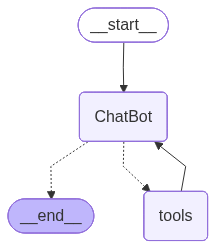

In [86]:
from IPython.display import Image, display
# Show the agent
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [91]:
user_input = 'Authors of the journal An Experimental Evaluation of Deep Learning-Based Models for Acne Severity Classification in Humans'
events  = graph.stream({'messages':[user_input]},stream_mode = "values")

for event in events:
  print(event['messages'][-1].content)

Authors of the journal An Experimental Evaluation of Deep Learning-Based Models for Acne Severity Classification in Humans

Page: Leprosy
Summary: Leprosy, also known as Hansen's disease (HD), is a long-term infection by the bacteria Mycobacterium leprae or Mycobacterium lepromatosis. Infection can lead to damage of the nerves, respiratory tract, skin, and eyes. This nerve damage may result in the loss of nociception, which can lead to the loss of parts of a person's extremities from repeated injuries or infection through unnoticed wounds. An infected person may also experience muscle weakness and loss of eyesight. L

Page: Leprosy
Summary: Leprosy, also known as Hansen's disease (HD), is a long-term infection by the bacteria Mycobacterium leprae or Mycobacterium lepromatosis. Infection can lead to damage of the nerves, respiratory tract, skin, and eyes. This nerve damage may result in the loss of nociception, which can lead to the loss of parts of a person's extremities from repeated 